In [1]:
!pip install transformers dataset --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.7 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  # Updated import location
from transformers import (AutoTokenizer, 
                         AutoModelForSequenceClassification,
                         get_linear_schedule_with_warmup)
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)  # Fixed typo: manual_seed instead of manual_seed
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


label
1    23481
0    21417
Name: count, dtype: int64


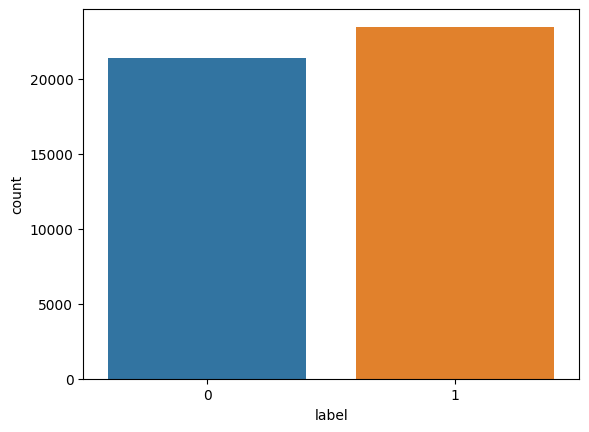

label
1    23481
0    21417
Name: count, dtype: int64


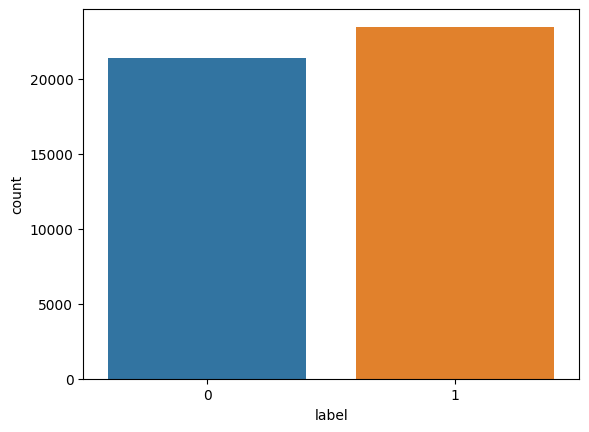


=== Sample Real News ===
California AG pledges to defend birth control insurance coverage SAN FRANCISCO (Reuters) - California Attorney General Xavier Becerra said on Friday he was “prepared to take whatever action it takes” to defend the Obamacare mandate that health insurers provide birth control, now that the Trump administration has moved to circumvent it. The administration’s new contraception exemptions “are another example of the Trump administration trampling on people’s rights, but in this case only women,” Bec...

=== Sample Fake News ===
 BREAKING: GOP Chairman Grassley Has Had Enough, DEMANDS Trump Jr. Testimony Donald Trump s White House is in chaos, and they are trying to cover it up. Their Russia problems are mounting by the hour, and they refuse to acknowledge that there are problems surrounding all of this. To them, it s  fake news,  or a  hoax.  However, the facts bear things out differently, and it seems that there are now cracks in the Congressional public leadersh

In [3]:
# Load datasets
true_news = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
fake_news = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')

# Add labels (1 for fake, 0 for real)
true_news['label'] = 0
fake_news['label'] = 1

# Combine datasets
df = pd.concat([true_news, fake_news], axis=0).sample(frac=1, random_state=SEED).reset_index(drop=True)

# Combine title and text for better context
df['text'] = df['title'] + ' ' + df['text']

# Check class distribution
print(df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.show()

# Check class distribution
print(df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.show()

# Debugging: Check for obvious patterns
print("\n=== Sample Real News ===")
print(df[df['label']==0]['text'].iloc[0][:500] + "...")

print("\n=== Sample Fake News ===")
print(df[df['label']==1]['text'].iloc[0][:500] + "...")

# Check for publisher names in text
print("\n=== Common Publishers ===")
print("Real news sources:", df[df['label']==0]['text'].str.extract(r'(Reuters|AP|BBC|CNN)')[0].value_counts().head())
print("Fake news sources:", df[df['label']==1]['text'].str.extract(r'(Infowars|TheOnion|NaturalNews)')[0].value_counts().head())

In [4]:
class Config:
    # Model selection (switch between 'bert' and 'roberta')
    MODEL_NAME = 'roberta'  # Change to 'roberta' to switch models
    
    # Hyperparameters
    MAX_LEN = 256
    BATCH_SIZE = 16
    EPOCHS = 3
    LEARNING_RATE = 2e-5
    
    # Model-specific settings
    if MODEL_NAME == 'bert':
        MODEL_PATH = 'bert-base-uncased'
    elif MODEL_NAME == 'roberta':
        MODEL_PATH = 'roberta-base'
    else:
        raise ValueError("MODEL_NAME must be either 'bert' or 'roberta'")

print(f"Selected model: {Config.MODEL_NAME.upper()} ({Config.MODEL_PATH})")

Selected model: ROBERTA (roberta-base)


In [5]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_PATH)

class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        # Convert to lists to avoid index issues
        self.texts = texts.tolist() if isinstance(texts, pd.Series) else list(texts)
        self.labels = labels.tolist() if isinstance(labels, pd.Series) else list(labels)
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=Config.MAX_LEN,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [6]:
# Train/Test split - now resetting indices
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Create datasets and dataloaders
train_dataset = NewsDataset(train_df['text'], train_df['label'])
test_dataset = NewsDataset(test_df['text'], test_df['label'])

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE)

In [7]:
model = AutoModelForSequenceClassification.from_pretrained(
    Config.MODEL_PATH,
    num_labels=2  # Binary classification
).to(device)

optimizer = AdamW(model.parameters(), lr=Config.LEARNING_RATE)
total_steps = len(train_loader) * Config.EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

2025-06-29 17:37:47.550004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751218667.732827      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751218667.786674      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    losses = []
    correct_predictions = 0
    
    for batch in tqdm(data_loader, desc='Training'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    accuracy = correct_predictions.double() / len(data_loader.dataset)
    avg_loss = np.mean(losses)
    
    return avg_loss, accuracy

In [9]:
def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct_predictions.double() / len(data_loader.dataset)
    avg_loss = np.mean(losses)
    classification_rep = classification_report(all_labels, all_preds, target_names=['Real', 'Fake'])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return avg_loss, accuracy, classification_rep, conf_matrix

In [10]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(Config.EPOCHS):
    print(f'\nEpoch {epoch + 1}/{Config.EPOCHS}')
    print('-' * 30)
    
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
    val_loss, val_acc, _, _ = eval_model(model, test_loader, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
    print(f'Validation loss: {val_loss:.4f}, accuracy: {val_acc:.4f}')


Epoch 1/3
------------------------------


Evaluating: 100%|██████████| 562/562 [01:19<00:00,  7.09it/s]


Train loss: 0.0084, accuracy: 0.9973
Validation loss: 0.0009, accuracy: 0.9998

Epoch 2/3
------------------------------


Evaluating: 100%|██████████| 562/562 [01:20<00:00,  7.01it/s]


Train loss: 0.0001, accuracy: 0.9999
Validation loss: 0.0012, accuracy: 0.9999

Epoch 3/3
------------------------------


Evaluating: 100%|██████████| 562/562 [01:20<00:00,  7.02it/s]


Train loss: 0.0000, accuracy: 1.0000
Validation loss: 0.0012, accuracy: 0.9999


Evaluating: 100%|██████████| 562/562 [01:20<00:00,  6.96it/s]



Test Results:
Accuracy: 0.9999

Classification Report:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      4311
        Fake       1.00      1.00      1.00      4669

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980


Confusion Matrix:


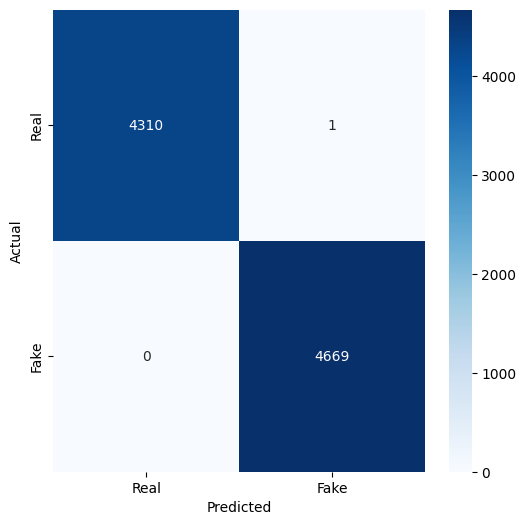

In [11]:
# Final evaluation
test_loss, test_acc, classification_rep, conf_matrix = eval_model(model, test_loader, device)

print('\nTest Results:')
print(f'Accuracy: {test_acc:.4f}')
print('\nClassification Report:')
print(classification_rep)

print('\nConfusion Matrix:')
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [4]:
output_dir = f'./{Config.MODEL_NAME}_fake_news_detector'
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model saved to {output_dir}")

NameError: name 'Config' is not defined